Replace old amplitude feature with the new one and test on the best performing model (LSTM)

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam, SGD
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Dropout, LeakyReLU
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
import time
import tensorflow as tf
import h5py

In [2]:
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)



In [5]:


data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()})  
df = a_t.merge(m_t, on='Time')


Input data:
            Time       V_filt  Vel_pc        SS
0       2102.90  5489.978529     0.0  5.656166
1       2102.91  5489.981454     0.0  5.657157
2       2102.92  5489.997639     0.0  5.658317
3       2102.93  5490.007016     0.0  5.659499
4       2102.94  5490.000189     0.0  5.660404
...         ...          ...     ...       ...
132394  3426.85  5459.380488     0.0  5.471059
132395  3426.86  5459.377762     0.0  5.474545
132396  3426.87  5459.388352     0.0  5.478286
132397  3426.88  5459.398820     0.0  5.481751
132398  3426.89  5459.399041     0.0  5.484813

[132399 rows x 4 columns]


In [16]:
data1 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/featamp.npz')
amp = pd.DataFrame(data1['FeatAmp'], columns={'NewAmp'})
t2 = pd.DataFrame(data1['Time'], columns={'Time'})
df2 = t2.join(amp)
print(df2)

           Time     NewAmp
0       2102.91  -3.000000
1       2102.92  -7.000000
2       2102.93  -1.666667
3       2102.94  -2.500000
4       2102.95  -1.400000
...         ...        ...
132370  3426.86 -61.549999
132371  3426.87 -61.599998
132372  3426.88 -62.000000
132373  3426.89 -62.174999
132374  3426.90 -62.150002

[132375 rows x 2 columns]


In [24]:
df3 = df.merge(df2, on='Time')
df3 = df3[['Time', 'NewAmp', 'V_filt', 'Vel_pc', 'SS']]
print(df3)
# xdf = df3.drop(['Time', 'SS'], axis=1)
# ydf = df3[['SS']]
# print(xdf)
# print(ydf)

           Time     NewAmp       V_filt  Vel_pc        SS
0       2102.91  -3.000000  5489.981454     0.0  5.657157
1       2102.92  -7.000000  5489.997639     0.0  5.658317
2       2102.93  -1.666667  5490.007016     0.0  5.659499
3       2102.94  -2.500000  5490.000189     0.0  5.660404
4       2102.95  -1.400000  5489.993164     0.0  5.661648
...         ...        ...          ...     ...       ...
132368  3426.85 -61.424999  5459.380488     0.0  5.471059
132369  3426.86 -61.549999  5459.377762     0.0  5.474545
132370  3426.87 -61.599998  5459.388352     0.0  5.478286
132371  3426.88 -62.000000  5459.398820     0.0  5.481751
132372  3426.89 -62.174999  5459.399041     0.0  5.484813

[132373 rows x 5 columns]


In [25]:
arr = df3.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

Features shape, X =  (132073, 300, 4)
Target shape, Y =  (132073,)


In [26]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95092, 300, 4)
Validation: (10566, 300, 4)
Testing: (26415, 300, 4)


Epoch 1/10
2972/2972 [==============================] - 32s 10ms/step - loss: 3.5279 - val_loss: 0.0132
Epoch 2/10
2972/2972 [==============================] - 31s 10ms/step - loss: 0.0096 - val_loss: 0.0077
Epoch 3/10
2972/2972 [==============================] - 30s 10ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 4/10
2972/2972 [==============================] - 31s 10ms/step - loss: 0.0075 - val_loss: 0.0096
Epoch 5/10
2972/2972 [==============================] - 31s 10ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 6/10
2972/2972 [==============================] - 31s 10ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 7/10
2972/2972 [==============================] - 31s 10ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/10
2972/2972 [==============================] - 31s 10ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 9/10
2972/2972 [==============================] - 31s 10ms/step - loss: 9.9576e-04 - val_loss: 0.0014
Epoch 10/10
2972/2972 [==============================] - 31s

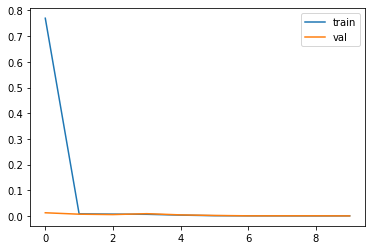

---Training time: 308.47411656 seconds ---
R2 scores: Train - 0.95428, Validation - 0.95068
RMSE scores: Train - 0.02749, Validation - 0.03279


In [34]:
# Build the model

np.random.seed(0)   # To get reproducible results
#tf.random.set_seed(1)

model = Sequential()
model.add(LSTM(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation=None))
model.compile(loss='mse', optimizer='adam')

start_time = time.time()
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

print("R2 scores: Train - %0.5f, Validation - %0.5f" %(train_r2, val_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f" %(train_rmse, val_rmse))

In [35]:
# Evaluate the model


start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("Test - \nR2 scores: %0.5f \nRMSE scores: %0.5f" %(test_r2, test_rmse))
print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))


Test - 
R2 scores: 0.74785 
RMSE scores: 0.07254

---Time for Test data prediction: 3.56500173 seconds ---


Text(0.5, 1.0, 'Shear Stress prediction using LSTM model')

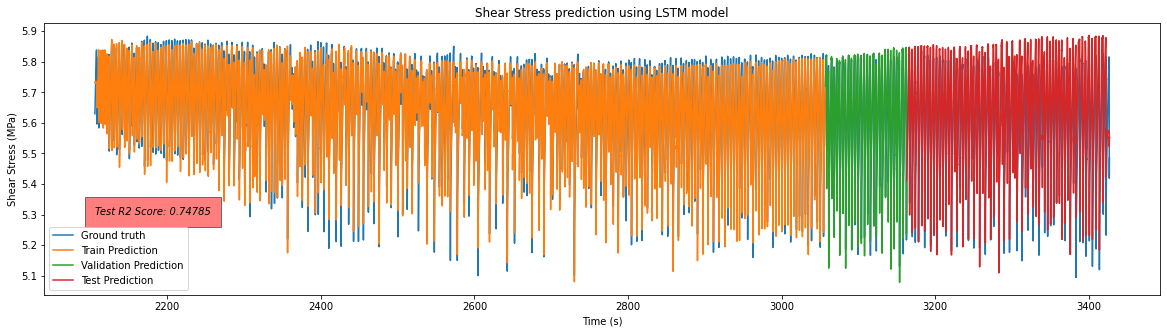

In [36]:
# Overall plot

ttime = df3['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.1, shuffle=False)

fig = plt.figure(1, figsize=(20,5))
plt.plot(ttime, ydf)
plt.plot(traintime, y_predTrain)
plt.plot(valtime, y_predVal)
plt.plot(testtime, y_predTest)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.text(ttime.iloc[0], 5.3, 'Test R2 Score: %0.5f' %(test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('Shear Stress prediction using LSTM model')

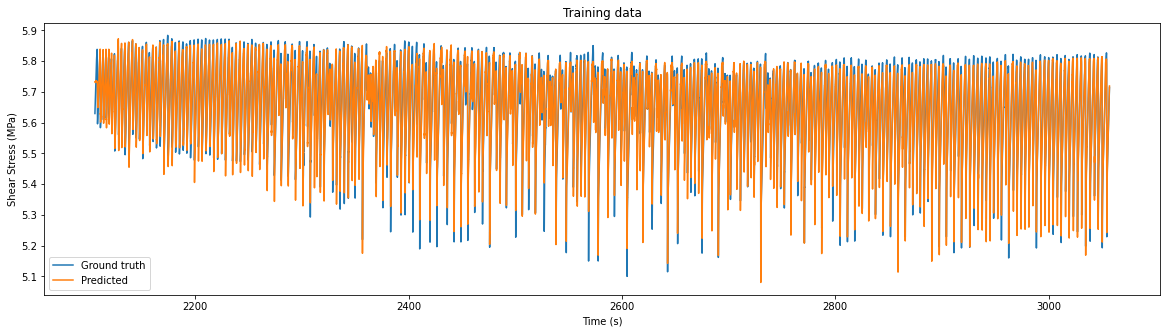

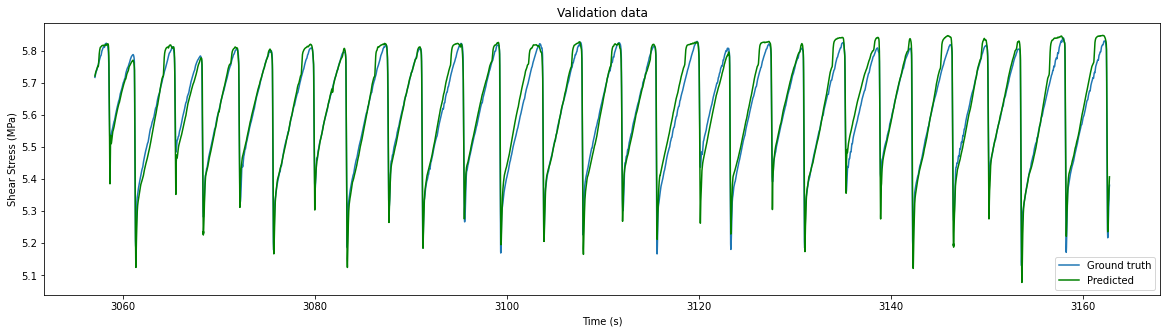

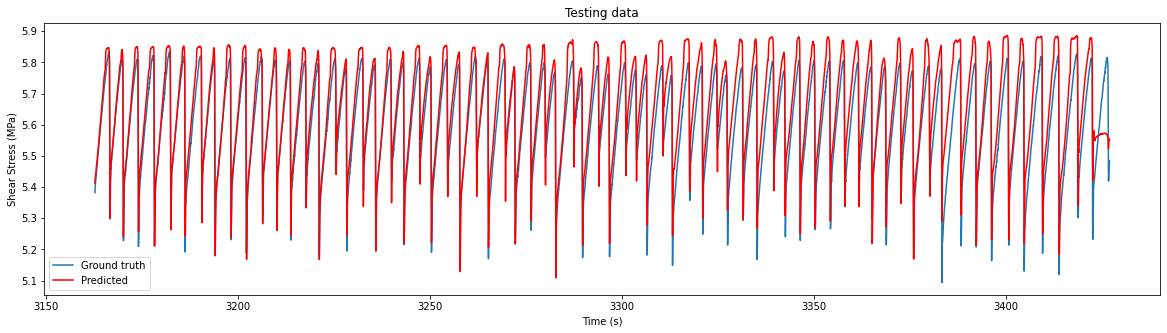

In [37]:
# Individual plots

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,5))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train, y_predTrain, 'Training data', '')
results_plot(2, valtime, Y_val, y_predVal, 'Validation data', 'g')
results_plot(3, testtime, y_test, y_predTest, 'Testing data', 'r')